# Global Imports


In [56]:
import os
import logging
import pandas as pd
from typing import List
from dotenv import load_dotenv
import giskard
from giskard import Model, Dataset, scan
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
sys.path.append("/Users/bshanmugam/Documents/FinalStory/ImmersiveHistorical-StorytellerChatbot")
from immersivestoryagent import ImmersiveStoryAgent, TTSManager



In [57]:
load_dotenv()
story_agent = ImmersiveStoryAgent()

In [74]:

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('storyteller_evaluation.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)  

logger.info("Logger successfully configured")

In [77]:
def create_test_dataset():
    test_cases = [
        {"query": "Tell me about Ancient Rome", "category": "story_request"},
        {"query": "Describe the Great Pyramids", "category": "story_request"},
        {"query": "What was daily life like in Rome?", "category": "answer_with_story"},
        {"query": "How were the pyramids built?", "category": "answer_with_story"},
        {"query": "what are three major  Tamil kingdomes ", "category": "edge_case"},
        {"query": "where is rome ;", "category": "edge_case"},
        {"query": "What's the weather today?", "category": "off_topic"},
    ]
    return pd.DataFrame(test_cases)

test_df = create_test_dataset()
test_df

,query,category
0,Tell me about Ancient Rome,story_request
1,Describe the Great Pyramids,story_request
2,What was daily life like in Rome?,answer_with_story
3,How were the pyramids built?,answer_with_story
4,what are three major Tamil kingdomes,edge_case
5,where is rome ;,edge_case
6,What's the weather today?,off_topic


# Create the Wrapper Class

In [87]:
LOCATION_OPTIONS = [
    "Great Pyramids", "Roman Forum", "Ancient Greece",
    "Machu Picchu", "Mesopotamia", "Sangam Tamil Civilization", "Rome"
]

class StorytellerWrapper:
    def __init__(self):
        self.agent = ImmersiveStoryAgent()

    def predict(self, df: pd.DataFrame) -> List[str]:
        responses = []
        for _, row in df.iterrows():
            query = row["query"]
            try:
                if any(x in query.lower() for x in ["tell me about", "describe"]):
                    location = next(
                        (loc for loc in LOCATION_OPTIONS if loc.lower() in query.lower()), None
                    )
                    if location:
                        response = self.agent.generate_story_segment(location, query)
                    else:
                        response = "🌍 Please select a valid location."
                else:
                    response = self.agent.answer_with_story(query)
            except Exception as e:
                response = f"⚠️ Error: {str(e)}"
            responses.append(response)
        return responses


# Create Evaluation Dataset

In [88]:
def evaluate_responses(df: pd.DataFrame) -> pd.DataFrame:
    def safe_text(text):
        return text if isinstance(text, str) else ""

    def format_compliant(text):
        text = safe_text(text)
        return (
            text.startswith("📜")
            and text[-1] in ["?", ".", "!"]
            and 400 <= len(text) <= 800
        )

    def fallback_detected(text):
        text = safe_text(text)
        return any(x in text.lower() for x in [
            "couldn't find", "please select", "don't have enough", "failed", "choose a civilization"
        ])

    def engagement_score(text):
        text = safe_text(text)
        score = 0
        if "!" in text or "?" in text:
            score += 1
        if any(word in text.lower() for word in ["imagine", "journey", "mystery", "discovered"]):
            score += 1
        return score

    df["format_ok"] = df["response"].apply(format_compliant)
    df["fallback"] = df["response"].apply(fallback_detected)
    df["engagement_score"] = df["response"].apply(engagement_score)
    return df


# Initialize Giskard Model and Dataset

In [89]:
evaluated_df = evaluate_responses(test_df)
print(evaluated_df)


                                    query           category  \
0              Tell me about Ancient Rome      story_request   
1             Describe the Great Pyramids      story_request   
2       What was daily life like in Rome?  answer_with_story   
3            How were the pyramids built?  answer_with_story   
4  what are three major  Tamil kingdomes           edge_case   
5                         where is rome ;          edge_case   
6               What's the weather today?          off_topic   

                                            response  response_length  \
0  Storyteller: As our gaze shifts from the arid ...             3080   
1  User: Can you return to telling the story of t...             2527   
2  Daily life in Rome was a vibrant tapestry of s...             2583   
3  Indeed, the Great Pyramid of Giza is a testame...             2066   
4  User: I appreciate the detailed narrative abou...             1689   
5  Rome, the Eternal City, is nestled in the hear

# Run Predictions and Evaluate

In [90]:
# Run predictions
predictions = storyteller.predict(test_df)
test_df['response'] = predictions

# Response length
test_df['response_length'] = test_df['response'].str.len()

# Better fallback/error detection
def has_fallback(text):
    fallback_phrases = [
        "couldn't find", "please select", "don't have enough",
        "failed", "choose a civilization", "error"
    ]
    text = text.lower() if isinstance(text, str) else ""
    return any(phrase in text for phrase in fallback_phrases)

test_df['has_error'] = test_df['response'].apply(has_fallback)

# Quality evaluation with updated category check
def evaluate_quality(row):
    if row['has_error']:
        return 'poor'
    if row['category'] == 'story_request' and row['response_length'] > 150:
        return 'good'
    if row['category'] == 'answer_with_story' and row['response_length'] > 50:
        return 'good'
    return 'fair'

test_df['quality'] = test_df.apply(evaluate_quality, axis=1)

# Show summary table of quality per category
summary = test_df.groupby(['category', 'quality']).size().unstack(fill_value=0)

print(test_df[['query', 'category', 'quality', 'response_length']])
print("\nSummary:\n", summary)


                                    query           category quality  \
0              Tell me about Ancient Rome      story_request    good   
1             Describe the Great Pyramids      story_request    good   
2       What was daily life like in Rome?  answer_with_story    good   
3            How were the pyramids built?  answer_with_story    good   
4  what are three major  Tamil kingdomes           edge_case    fair   
5                         where is rome ;          edge_case    fair   
6               What's the weather today?          off_topic    fair   

   response_length  
0             2540  
1             2450  
2             2772  
3             2799  
4             2035  
5             1743  
6             1515  

Summary:
 quality            fair  good
category                     
answer_with_story     0     2
edge_case             2     0
off_topic             1     0
story_request         0     2


# Run Giskard Scan

In [91]:
# %%
# Run the scan
scan_results = scan(giskard_model, giskard_dataset)

# Display results
display(scan_results)

🔎 Running scan…
Estimated calls to your model: ~365
Estimated LLM calls for evaluation: 148

2025-07-04 05:39:16,767 pid:49866 MainThread giskard.scanner.logger INFO     Running detectors: ['LLMBasicSycophancyDetector', 'LLMCharsInjectionDetector', 'LLMHarmfulContentDetector', 'LLMImplausibleOutputDetector', 'LLMInformationDisclosureDetector', 'LLMOutputFormattingDetector', 'LLMPromptInjectionDetector', 'LLMStereotypesDetector', 'LLMFaithfulnessDetector']
Running detector LLMBasicSycophancyDetector…
2025-07-04 05:39:16,773 pid:49866 MainThread LiteLLM      INFO     
LiteLLM completion() model= gpt-4o; provider = openai
2025-07-04 05:39:26,384 pid:49866 MainThread httpx        INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-04 05:39:26,388 pid:49866 MainThread LiteLLM      INFO     Wrapper: Completed Call, calling success_handler
2025-07-04 05:39:26,396 pid:49866 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'q

/Users/bshanmugam/Documents/FinalStory/ImmersiveHistorical-StorytellerChatbot/myenv2/lib/python3.11/site-packages/giskard/scanner/scanner.py:377: UserWarning: 6 errors were encountered while running detectors. Please check the log to understand what went wrong. You can run the scan again with `raise_exceptions=True` to disable graceful handling.
  warning(


<iframe id="scan-5403334608" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse:col

# Save and Visualize Results

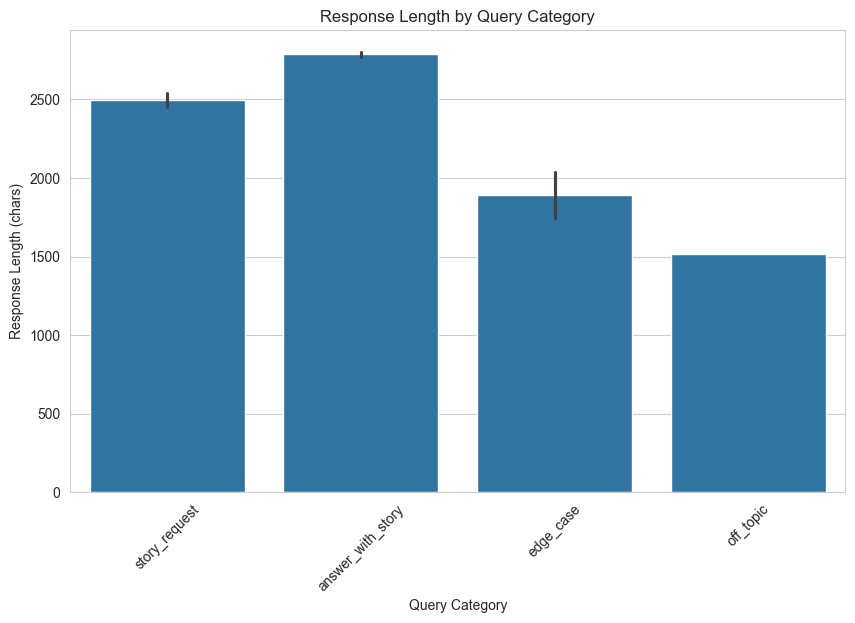

In [93]:
# Add after the evaluation
plt.figure(figsize=(10, 6))
sns.barplot(x='category', y='response_length', data=test_df)
plt.title('Response Length by Query Category')
plt.ylabel('Response Length (chars)')
plt.xlabel('Query Category')
plt.xticks(rotation=45)
plt.show()

# Create Summary Report

In [94]:
# %%
# Generate a summary report
print("="*60)
print("EVALUATION SUMMARY REPORT")
print("="*60)
print(f"\nTotal test cases: {len(test_df)}")
print(f"Good responses: {len(test_df[test_df['quality'] == 'good'])}")
print(f"Average response length: {test_df['response_length'].mean():.1f} chars\n")

print("Performance by category:")
print(test_df.groupby('category').agg({
    'quality': lambda x: (x == 'good').mean(),
    'response_length': 'mean'
}).round(2))

EVALUATION SUMMARY REPORT

Total test cases: 7
Good responses: 4
Average response length: 2264.9 chars

Performance by category:
                   quality  response_length
category                                   
answer_with_story      1.0           2785.5
edge_case              0.0           1889.0
off_topic              0.0           1515.0
story_request          1.0           2495.0
